In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import defaultdict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.feature_selection import mutual_info_classif

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


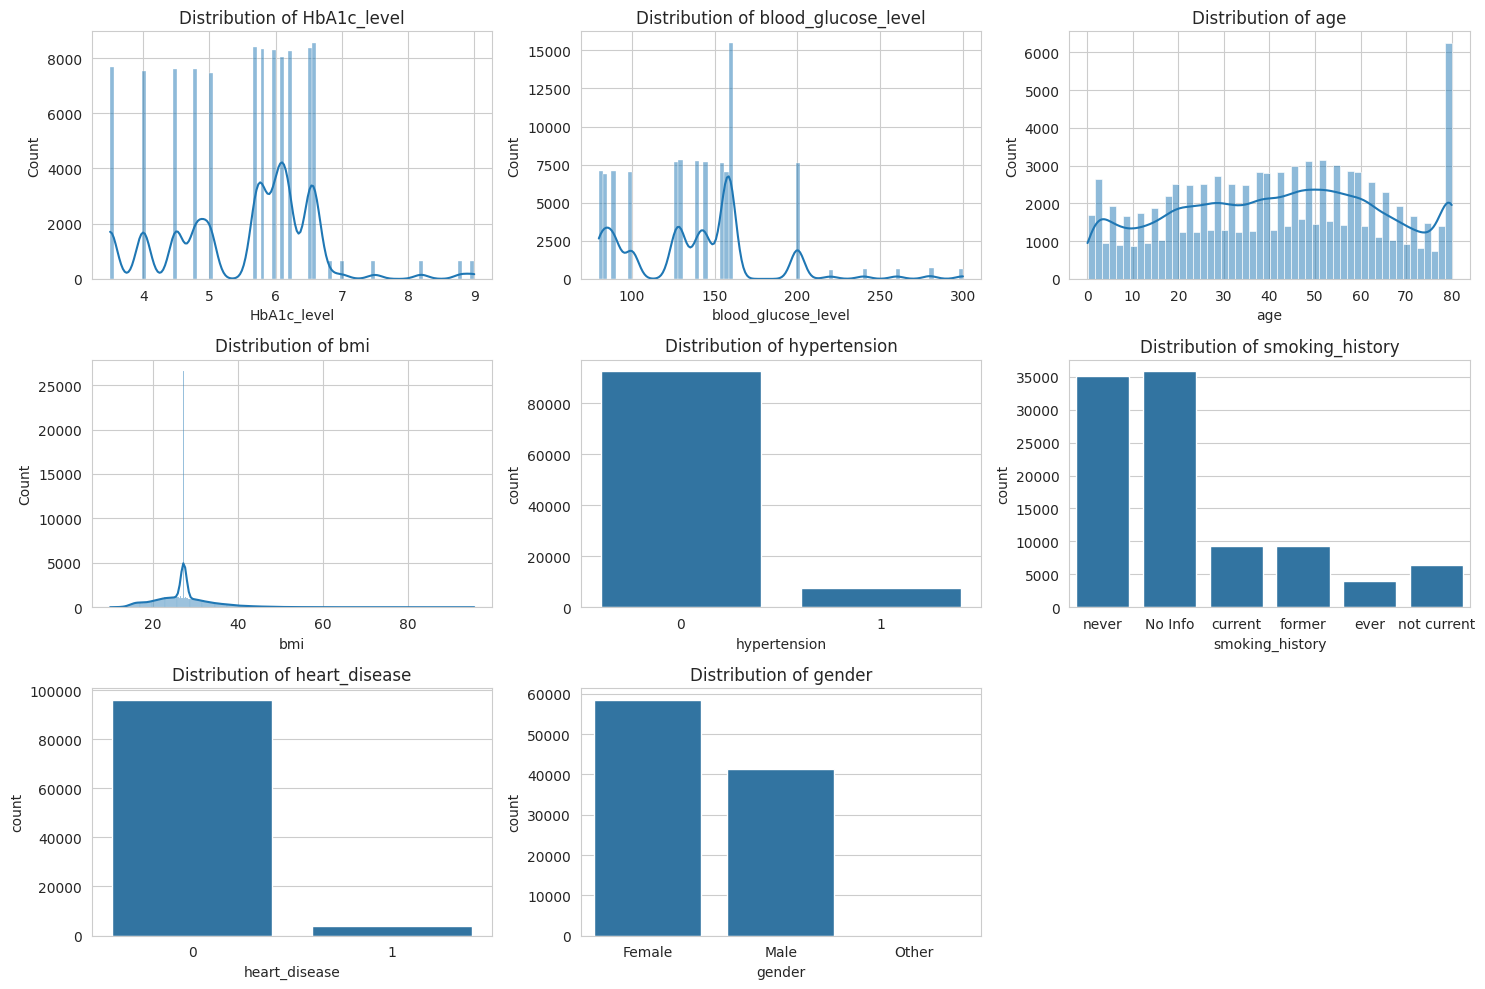

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/diabetes_prediction_dataset.csv')

plt.figure(figsize=(15, 10))

cont = ['HbA1c_level', 'blood_glucose_level', 'age', 'bmi']
for i, var in enumerate(cont, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df2[var], kde=True)
    plt.title(f'Distribution of {var}')

cat = ['hypertension', 'smoking_history', 'heart_disease', 'gender']
for i, var in enumerate(cat, len(cont) + 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=var, data=df2)
    plt.title(f'Distribution of {var}')

plt.tight_layout()

plt.show()

Label Encoding for Categorical Variables

In [ ]:
#We will not encode numerical columns such as age, BMI, HbA1c level, blood glucose level. In addition, binary columns such as hyptertension,
# heart disease, and diabetes are already in binary format. Thus, we will proceed to encode 'gender' and 'smoking_history'.

from sklearn.preprocessing import LabelEncoder
import pandas as pd
import io

label_encoder = LabelEncoder()

#gender column
df['gender_encoded'] = label_encoder.fit_transform(df['gender'])

#smoking history
df['smoking_history_encoded'] = label_encoder.fit_transform(df['smoking_history'])

df = df[['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes', 'gender_encoded', 'smoking_history_encoded']]
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_encoded,smoking_history_encoded
0,80.0,0,1,25.19,6.6,140,0,0,4
1,54.0,0,0,27.32,6.6,80,0,0,0
2,28.0,0,0,27.32,5.7,158,0,1,4
3,36.0,0,0,23.45,5.0,155,0,0,1
4,76.0,1,1,20.14,4.8,155,0,1,1


Feature Scaling

Selecting Features To Scale:
We are defining which features to scale, which are the continuous numerical features. Categorical features have already been encoded in the previous step.

In [ ]:
numerical_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']

We are using standardization for the numerical features.

In [ ]:
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_encoded,smoking_history_encoded
0,1.692704,-0.284439,4.936379,-0.321056,1.001706,0.047704,0,0,4
1,0.538006,-0.284439,-0.202578,-0.000116,1.001706,-1.426210,0,0,0
2,-0.616691,-0.284439,-0.202578,-0.000116,0.161108,0.489878,0,1,4
3,-0.261399,-0.284439,-0.202578,-0.583232,-0.492690,0.416183,0,0,1
4,1.515058,3.515687,4.936379,-1.081970,-0.679490,0.416183,0,1,1


Now, we will use mutual information to perform feature selection. Mutual information is a non-negative value that measures the dependency between the variables. A larger value indicates a stronger relationship with the target variable.

In [ ]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

mutual_info = mutual_info_classif(X, y)
mutual_info_df = pd.DataFrame({'feature': X.columns, 'mutual_info': mutual_info})
mutual_info_sorted = mutual_info_df.sort_values('mutual_info', ascending=False)
mutual_info_sorted
selected_features = mutual_info_sorted[mutual_info_sorted['mutual_info'] > 0]['feature']

df = df[selected_features.tolist() + ['diabetes']]
df.head()

,HbA1c_level,blood_glucose_level,age,bmi,hypertension,smoking_history_encoded,heart_disease,gender_encoded,diabetes
0,1.001706,0.047704,1.692704,-0.321056,-0.284439,4,4.936379,0,0
1,1.001706,-1.426210,0.538006,-0.000116,-0.284439,0,-0.202578,0,0
2,0.161108,0.489878,-0.616691,-0.000116,-0.284439,4,-0.202578,1,0
3,-0.492690,0.416183,-0.261399,-0.583232,-0.284439,1,-0.202578,0,0
4,-0.679490,0.416183,1.515058,-1.081970,3.515687,1,4.936379,1,0


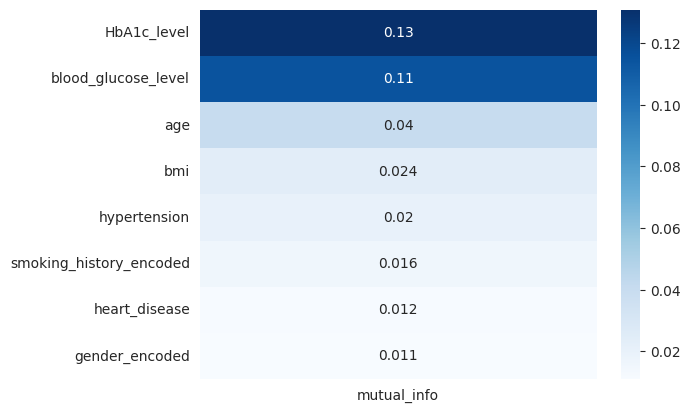

In [ ]:
mutual_info = mutual_info_classif(X, y)
sns.heatmap(pd.DataFrame(mutual_info, index=X.columns, columns=['mutual_info']), cmap="Blues", annot=True)
plt.show()

The DataFrame remains unchanged with all original features plus the diabetes target column. However, with such a small dataset (as the one shown), the reliability of mutual information scores and other feature selection methods may be compromised. This concludes preprocessing, and the model can be built.

Model Implementation - Logistic Regression

Logistic regression was chosen since it works well for binary classification tasks. It simulates the likelihood that an input falls into a specific category (in this case, diabetes or not).



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}\n")
conf_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("Confusion Matrix:")
print(conf_matrix_df)
print("\n")
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("Classification Report:")
print(report_df)

Accuracy: 0.95865

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               18127                 165
Actual Positive                 662                1046


Classification Report:
              precision    recall  f1-score      support
0              0.964767  0.990980  0.977697  18292.00000
1              0.863749  0.612412  0.716684   1708.00000
accuracy       0.958650  0.958650  0.958650      0.95865
macro avg      0.914258  0.801696  0.847191  20000.00000
weighted avg   0.956140  0.958650  0.955407  20000.00000


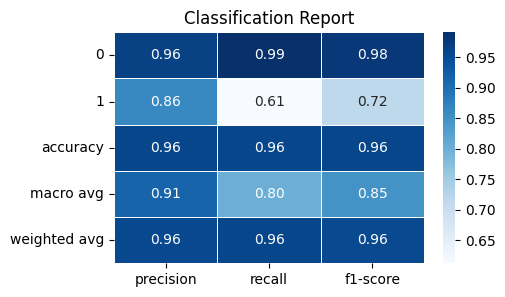

In [ ]:
#no need for support
performance_metrics_df = report_df.drop('support', axis=1)

plt.figure(figsize=(5, 3))
sns.heatmap(performance_metrics_df, annot=True, cmap="Blues", linewidths=.5, fmt=".2f")
plt.title('Classification Report')
plt.show()


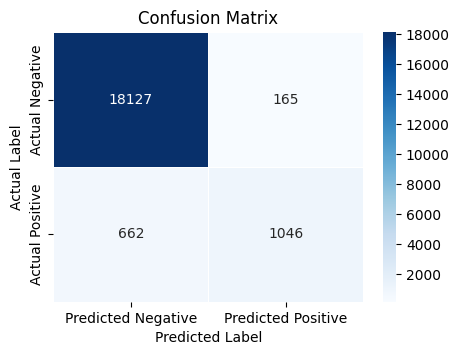

In [ ]:
plt.figure(figsize=(5, 3.5))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Quantitative Metrics

Given the values from the confusion matrix:


**True Negative (TN)**: 18127 \\
**False Positive (FP)**: 165 \\
**False Negative (FN)**: 662 \\
**True Positive (TP)**: 1046 \\


The formulas for the quantative metrics are:

\begin{align*}
    \text{Accuracy} &= \frac{TP + TN}{TP + TN + FP + FN} \\
    \text{Recall} &= \frac{TP}{TP + FN} \\
    \text{Precision} &= \frac{TP}{TP + FP} \\
    \text{F1} &= 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\end{align*}

Evaluating the formulas with the above values we get:

\begin{align*}
    \text{Accuracy} &= \frac{1046 + 18127}{1046 + 18127 + 165 + 662} \approx 95.865\% \\
    \text{Recall} &= \frac{1046}{1046 + 662} \approx 61.241\% \\
    \text{F1 Score} &= 2 \times \frac{\frac{1046}{1046 + 165} \times \frac{1046}{1046 + 662}}{\frac{1046}{1046 + 165} + \frac{1046}{1046 + 662}} \approx 71.668\%
\end{align*}

# Analysis

### Classification Report
The report for each class (0 for the negative class which represents non-diabetes cases, and 1 for the positive class which likely represents diabetes cases) shows precision, recall, and f1-score.

- **Precision**: This is the ratio of correctly predicted positive cases to the total predicted positive cases. So essentially, a high precision implies a low false positive rate. For the non-diabetes class (0), the precision is approximately 96.47%, which is relatively high. This suggests that the model is reliable in predicting cases of non-diabetes. For the diabetes class (1), the precision is approximately 86.37%, which is not as precise as the non-diabetes class, but still reasonably high. This indicates that most of the cases predicted as diabetes are actually diabetes.

- **Recall**: This is the ratio of correctly predicted positive cases to all cases in the class, also known as the true positive rate. The non-diabetes (0) class has a recall of approximately 99.90%, which shows that the model is very good at predicting non-diabetes cases. But on the other hand, the diabetes class (1) has a lower recall of about 61.24%. This suggests that the model misses a good number of actual diabetes cases.

- **F1-Score**: This is the harmonic mean of precision and recall. So, it assesses both false positives and false negatives and shows if a class has a balance of precision and recall. The F1 score for the non-diabetes class (0) is approximately 97.77%, while for the diabetes class (1) it's lower at 71.66%. This suggest that there is not a good balance between precision and recall for the diabetes class.

### Confusion Matrix and Overall Metrics

- **Accuracy**: This is the ratio of correctly predicted cases to the total number of cases. The overall accuracy is 95.86%, which is implies a high-performing model.

- **Macro Average**: This averages the unweighted mean per label, so it doesn't take label imbalance into account. The macro average for precision, recall, and F1-score are approximately 91.42%, 80.16%, and 84.72% respectively. This suggests the model performs well overall, but there is an imbalance in performance between the two classes.

- **Weighted Average**: This averages the support-weighted mean per label. This accounts for label imbalance by weighing the metrics by the number of true instances for each label. Support is the number of cases of a class in the dataset. The weighted averages for precision, recall, and F1-score are approximately 95.61%, 95.86%, and 95.54% respectively, which suggests that when noting the imbalance, the model still demonstrates a high performance.

### Remarks

In the context of predicting diabetes, the relatively low recall for diabetes cases (1) is something that needs to improve, because it suggests that the model fails to predict a decent portion of actual positive diabetes cases. This is an important issue especially considering this is used in the context of medical diagnosis as failing to diagnose a disease could lead to serious health problems experienced by the patient.

# Next Steps
A goal to improve this model would be to address it's low recall. There are multiple different approaches that can be taken to mitigate this issue. We can try lowering the threshold of 0.5 in the logisitic regression model. However, this might lead to more false positives. We could also implement more cost-sensitive training through the class_weight parameter. We can adjust this parameter to penalize when there's a misclassification of the positive class more than the negative class. This will incentivize the model to reduce the number of false negatives and thereby increase recall. Finally, we could employ more feature training to have better distinctions between the two classes. By denoising our model and removing irrelevant features, the model can become better at identifying true positive cases (which it was lacking in previously).

